<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/example%20time%20series%20ECG%20processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opensignalsreader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks,peak_prominences
from opensignalsreader import OpenSignalsReader
from numpy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
import scipy.signal as sig
%matplotlib inline

Importamos los datos del .txt generado por OpenSignals y los pasamos a un formato legible para la función de scipy find_peaks,  extraemos los datos necesarios y excluímos los datos pertenecientes a otros complejos, ondas y el ruido seleccionando un rango de alturas razonable para después hacer una media del valor de los picos y llevarlos a nuestro estudio.

In [4]:
def findHeight (data,peaks):
    mins = [0]
    maxs = [0]
    rango = [0]
    for i in range(0,len(peaks)):
        rango = data[int(peaks[i])-80:int(peaks[i])+120]
        mins.append(min(rango))
        maxs.append(max(rango))
    heights = np.zeros_like(mins)
    for i in range(0,len(maxs)):
        heights[i]=maxs[i]-mins[i]
    return heights

def conversor (data):
    datos = np.zeros_like(data)
    n = 10 #channel bits
    VCC = 3.3 #operating voltage (V)
    Gecg = 1100 #ganancia del sensor
    for i in range(0,len(data)):
        datos[i] = ((((data[i]/(pow(2,n)))-(1/2))*VCC)/Gecg)*1000
    return datos

--2025-02-25 11:24:12--  https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/SampleECG.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344150 (336K) [text/plain]
Saving to: ‘SampleECG.txt’

SampleECG.txt       100%[===================>] 336.08K  --.-KB/s    in 0.05s   

2025-02-25 11:24:13 (7.18 MB/s) - ‘SampleECG.txt’ saved [344150/344150]

/bin/bash: -c: line 1: syntax error near unexpected token `txt_link'
/bin/bash: -c: line 1: `wget(txt_link)'
media amplitudes = 0.65419921875
tiempo transcurrido: 22.35 picos detectados: 29
frecuencia cardiaca = 77.85234899328859


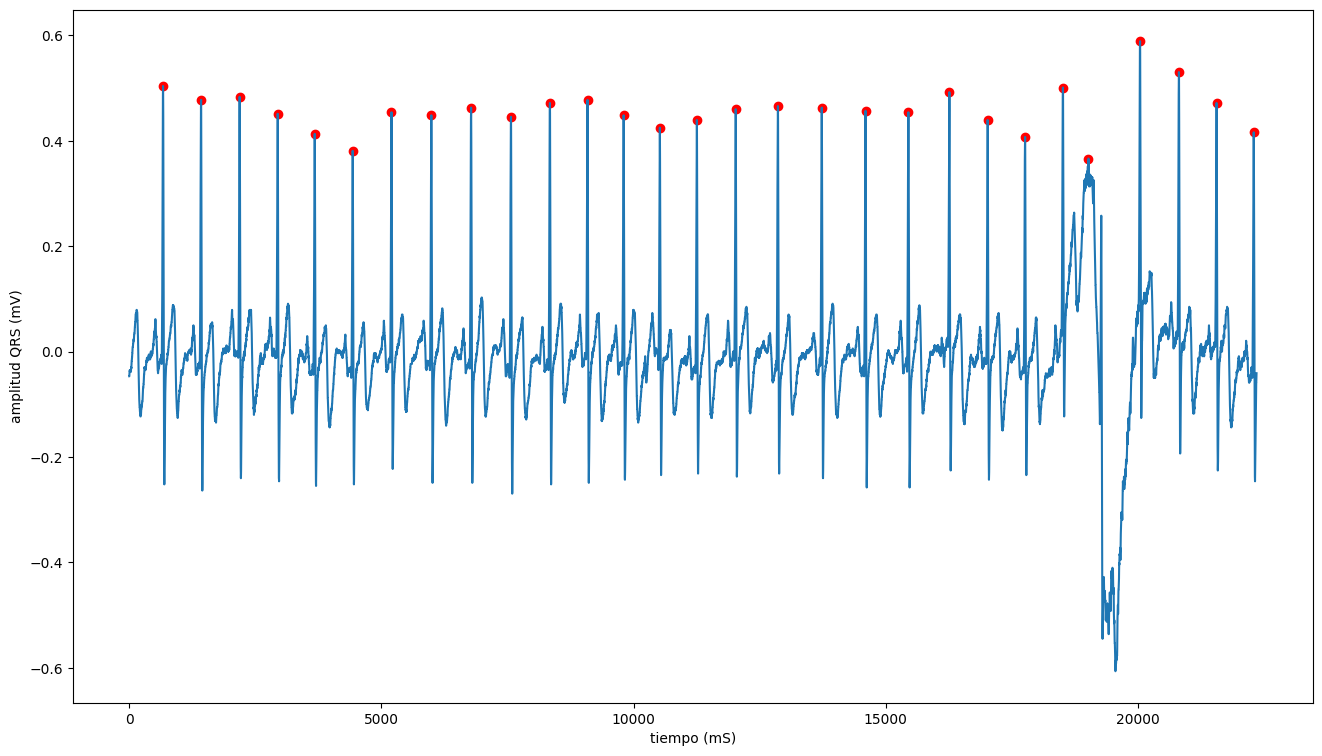

In [24]:
github_url = 'https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/SampleECG.txt'

local_file_name = 'SampleECG.txt'

!wget -O {local_file_name} {github_url}

!wget(txt_link)
#acq = OpenSignalsReader('SampleECG.txt')
acq = OpenSignalsReader(local_file_name)
data = acq.raw('ECG') #valores que toma el ECG

converted_data = conversor(data[:]) #datos en mV
peaks, _ = find_peaks(converted_data,height=[0.0,2.0],prominence = 0.35,distance = 300) #posición de los picos del ECG
alturas = findHeight(converted_data,peaks)
print('media amplitudes = ' + str(np.mean(alturas))) #media de las amplitudes del complejo QRS del ECG

print('tiempo transcurrido: ' + str(converted_data.size/1000) + ' picos detectados: ' + str(peaks.size)) #intervalo de tiempo (S) en el que se realizó el experimento y picos válidos para el estudio
print('frecuencia cardiaca = ' + str((peaks.size/(converted_data.size/1000))*60)) #frecuencia cardiaca
values = converted_data[peaks] #valores de los picos del ECG
plt.figure(figsize = (16,9))
plt.xlabel('tiempo (mS)')
plt.ylabel('amplitud QRS (mV)')
plt.plot(peaks,values, "or",); plt.plot(converted_data);

/usr/local/lib/python3.11/dist-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.11/dist-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


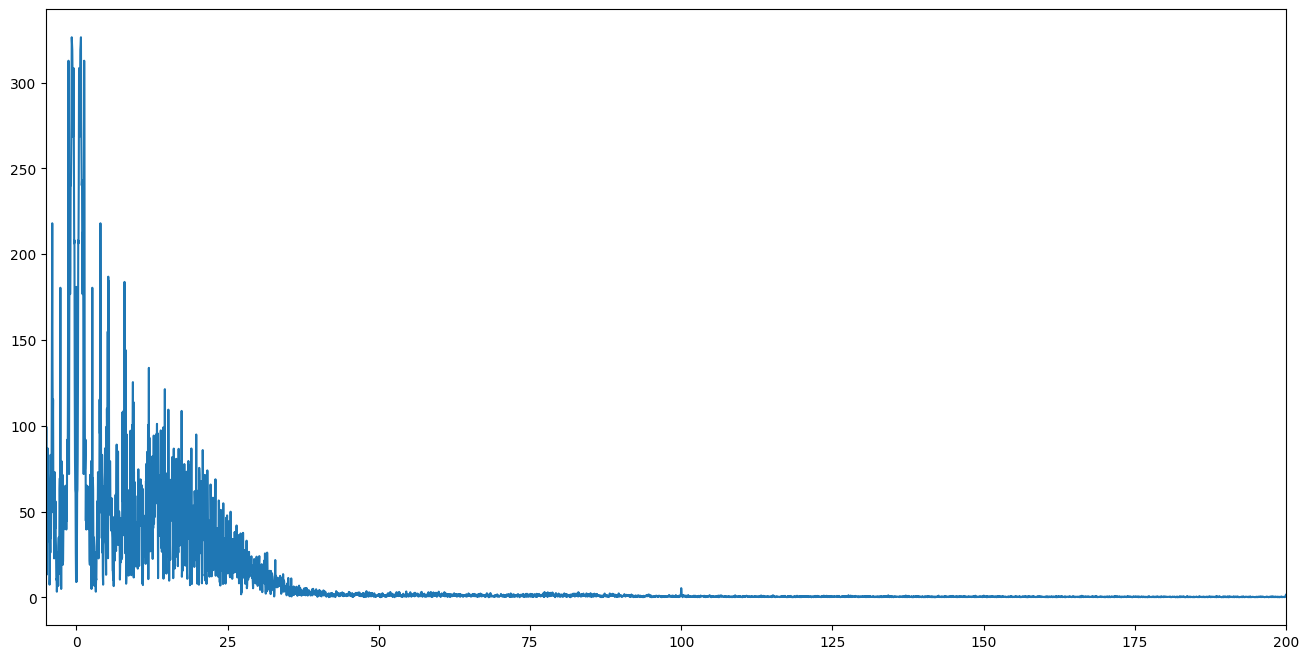

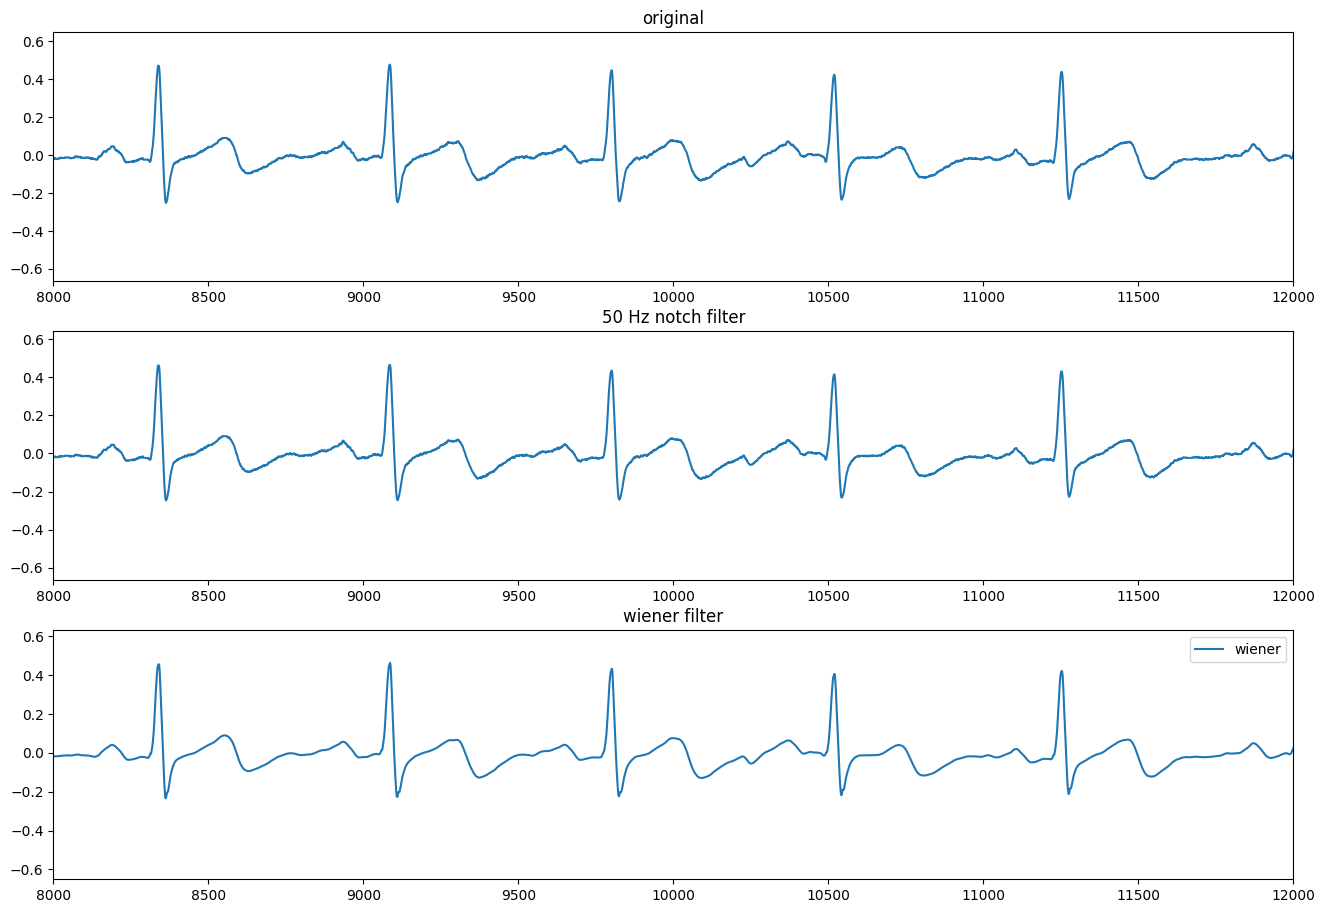

In [6]:
fs = 1000
X = fft(converted_data)
F = fftfreq(len(X))
f = F * fs

X = fftshift(X)
f =fftshift(f)

plt.figure(figsize=(16,8))
plt.plot(f,abs(X))
plt.xlim(-5,200)

Nwindow = 21
xwiener = sig.wiener(converted_data, Nwindow) #ESTE ES EL ECG CON EL MEJOR FILTRO

fnyquist = fs / 2
fnotch = 50 / fnyquist
b, a = sig.iirnotch(fnotch, 4)
x1_filtered = sig.filtfilt(b, a, converted_data)

plt.figure(figsize=(16,11))
plt.subplot(311)
plt.plot(converted_data, label = "original")
plt.title('original')
plt.xlim(8000,12000)
plt.subplot(312)
plt.plot(x1_filtered, label = "notch")
plt.title('50 Hz notch filter')
plt.xlim(8000,12000)
plt.subplot(313)
plt.plot(xwiener, label = "wiener")
plt.title('wiener filter')
plt.xlim(8000,12000)
plt.legend()

media amplitudes = 0.6188447491274889
tiempo transcurrido: 22.35 picos detectados: 29
frecuencia cardiaca = 77.85234899328859


(8000.0, 12000.0)

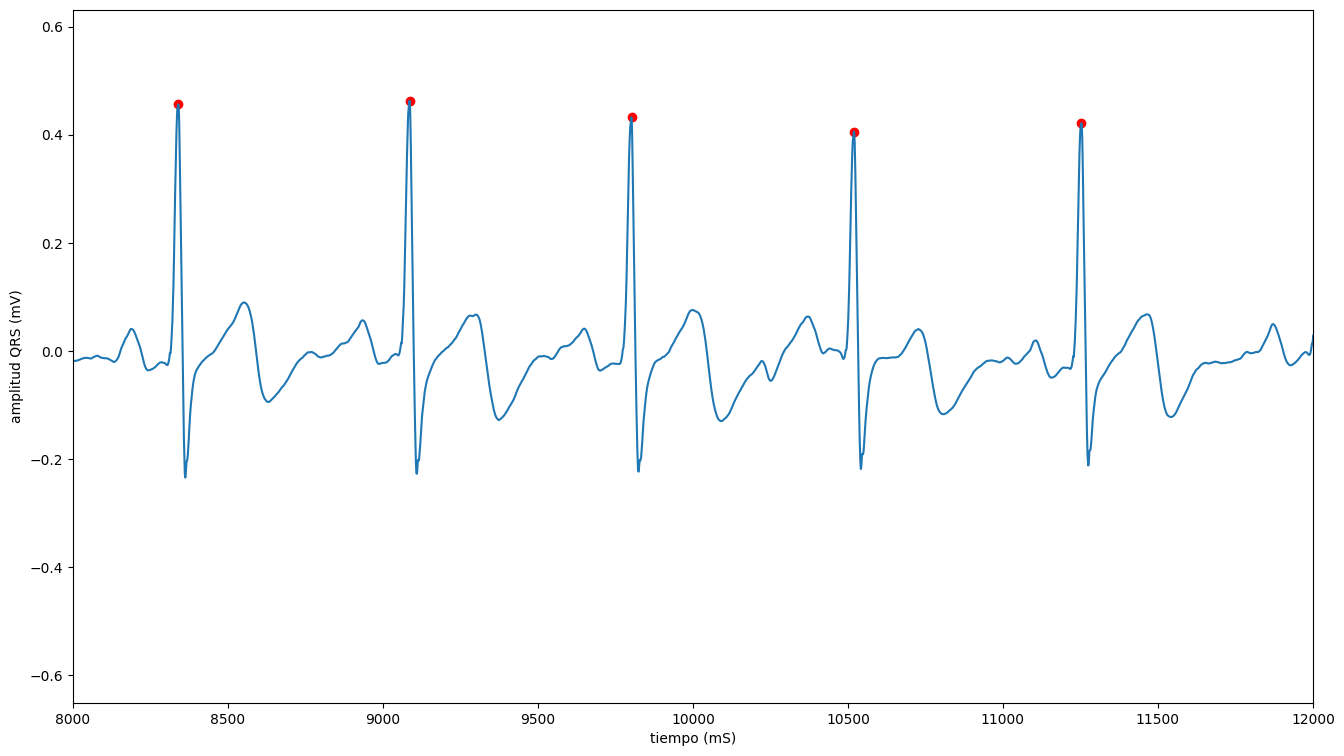

In [7]:
peaks2, _ = find_peaks(xwiener,height=[0.0,2.0],prominence = 0.35,distance = 300) #posición de los picos del ECG
alturas2 = findHeight(xwiener,peaks2)
print('media amplitudes = ' + str(np.mean(alturas2))) #media de las amplitudes del complejo QRS del ECG

print('tiempo transcurrido: ' + str(xwiener.size/1000) + ' picos detectados: ' + str(peaks.size)) #intervalo de tiempo (S) en el que se realizó el experimento y picos válidos para el estudio
print('frecuencia cardiaca = ' + str((peaks2.size/(xwiener.size/1000))*60)) #frecuencia cardiaca
values2 = xwiener[peaks2] #valores de los picos del ECG
plt.figure(figsize = (16,9))
plt.xlabel('tiempo (mS)')
plt.ylabel('amplitud QRS (mV)')
plt.plot(peaks2,values2, "or",); plt.plot(xwiener);
plt.xlim(8000,12000)

## Implementing Pan-Tompkins algorithm to extract the QRS complex
### Low-pass and high- pass filtering

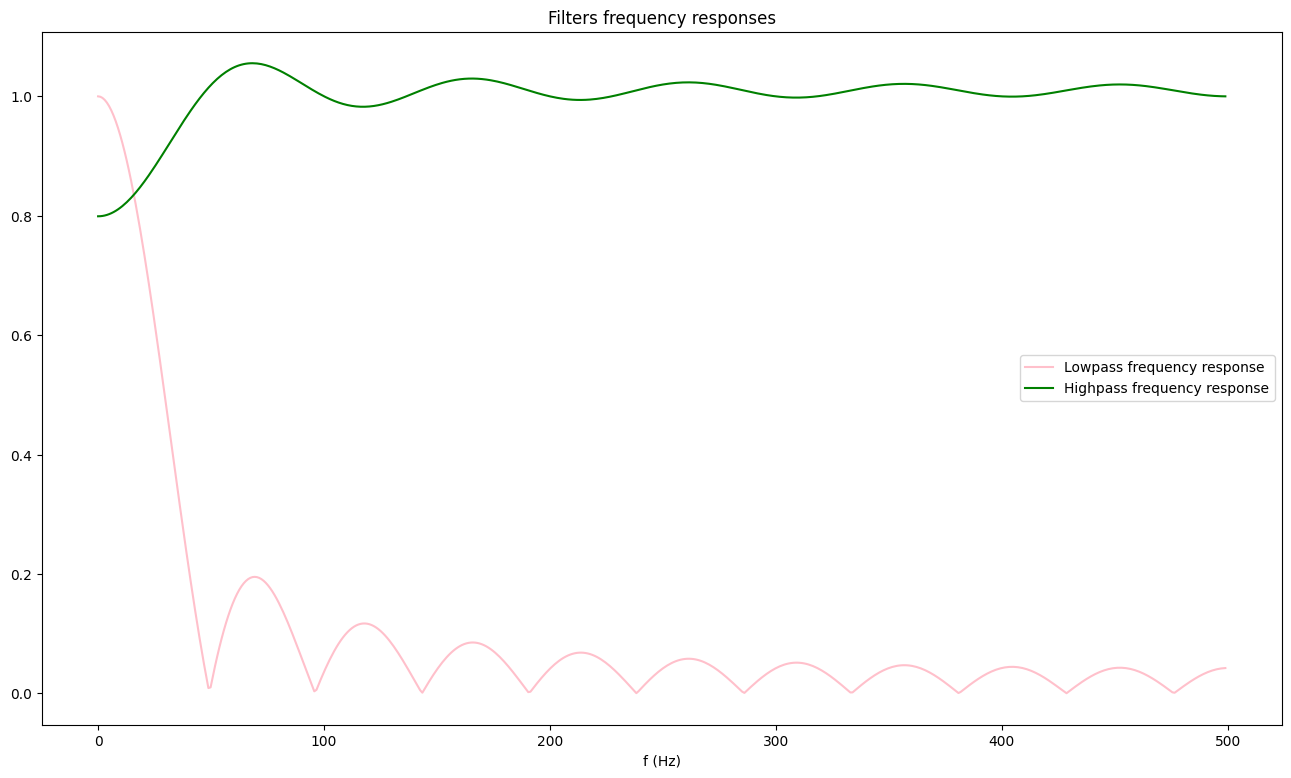

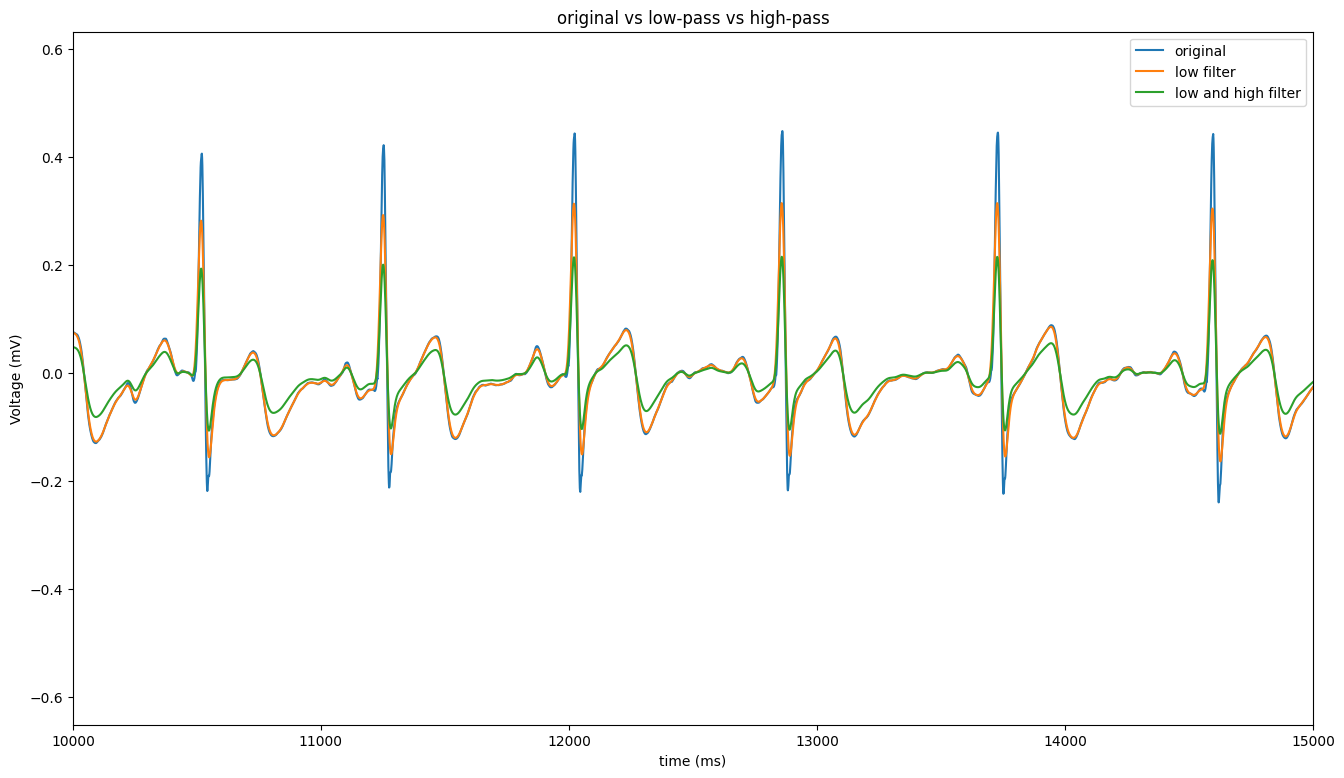

In [8]:
ecg = xwiener
fs = 1000 #Hz
nyquistfreq = fs / 2

#Low pass fc = 15
low_fc = 15 / nyquistfreq
N_low = 21
b_firwin = sig.firwin(N_low, low_fc, window='boxcar', pass_zero='lowpass')
Omega_low, H_low = sig.freqz(b_firwin, 1)
F_low = Omega_low / (2*np.pi)
f_low = F_low * fs
plt.figure(figsize=(16, 9))
plt.plot(f_low,abs(H_low),color = "pink")

#High pass fc = 5
high_fc = 5 / nyquistfreq
N_high = 21
bhigh_firwin = sig.firwin(N_high,high_fc,window='boxcar',pass_zero="highpass")
Omega_high, H_high = sig.freqz(bhigh_firwin, 1)
F_high = Omega_high / (2*np.pi)
f_high = F_high * fs
plt.plot(f_high,abs(H_high),color = "green")
plt.xlabel("f (Hz)")
plt.title("Filters frequency responses")
plt.legend(["Lowpass frequency response","Highpass frequency response"])

#applying filters
ecg_low_filtered = sig.filtfilt(b_firwin,1,ecg)
ecg_lowhigh_filtered = sig.filtfilt(bhigh_firwin,1,ecg_low_filtered)

plt.figure(figsize=(16, 9))
plt.plot(ecg, label = 'original')
plt.plot(ecg_low_filtered, label = 'low filter')
plt.plot(ecg_lowhigh_filtered, label = 'low and high filter')
plt.xlim(10000, 15000)
plt.xlabel('time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('original vs low-pass vs high-pass')
plt.legend()

### Savitsky-Golay Differentiator

Text(0, 0.5, 'ecg signals')

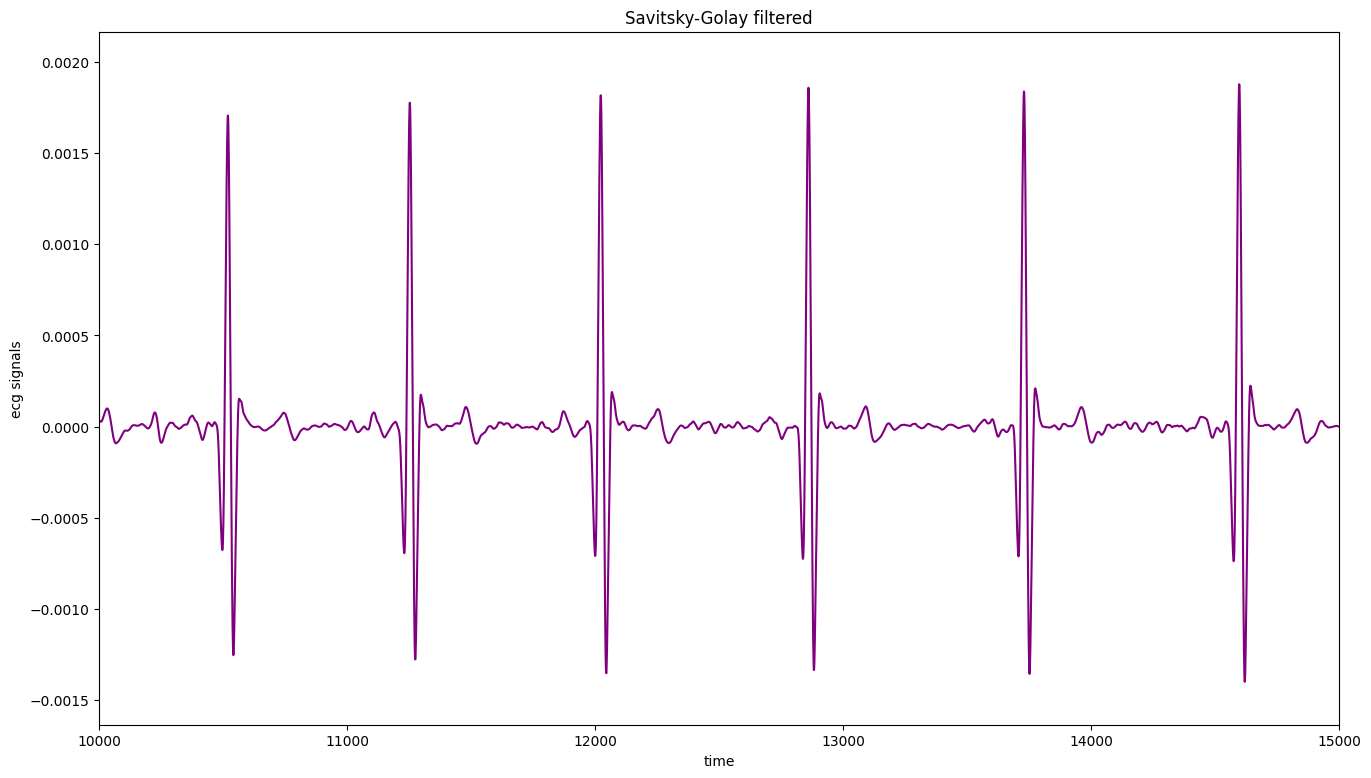

In [9]:
N_savgol = 51
order_polynomial = 11
x_axis = np.arange(len(ecg_lowhigh_filtered))

b_savgol = sig.savgol_coeffs(N_savgol, order_polynomial, deriv = 1)
ecg_savgol = sig.filtfilt(b_savgol, 1, ecg_lowhigh_filtered)

plt.figure(figsize=(16,9))
plt.plot(ecg_savgol,color="purple")
plt.title("Savitsky-Golay filtered")
plt.xlim(10000,15000)
plt.xlabel("time")
plt.ylabel("ecg signals")

### Squaring operation

Text(0.5, 1.0, 'Signal squared')

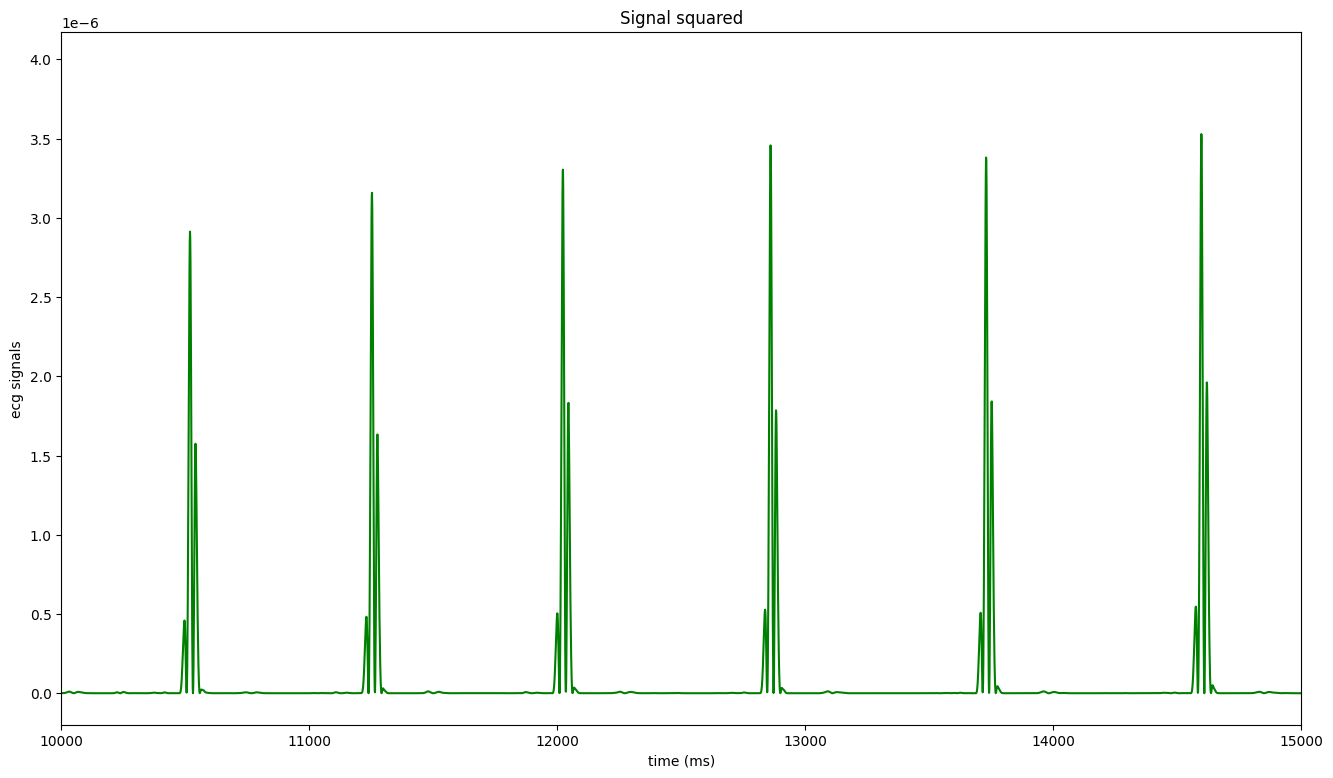

In [10]:
ecg_squared = ecg_savgol**2

plt.figure(figsize=(16,9))
plt.plot(ecg_squared,color="green")
plt.xlim(10000,15000)
plt.xlabel("time (ms)")
plt.ylabel("ecg signals")
plt.title("Signal squared")

### Moving-window integrator

[5.65455497e-21 1.08615947e-05 2.17839021e-05 ... 1.05407649e-02
 5.27038592e-03 4.13590306e-19]


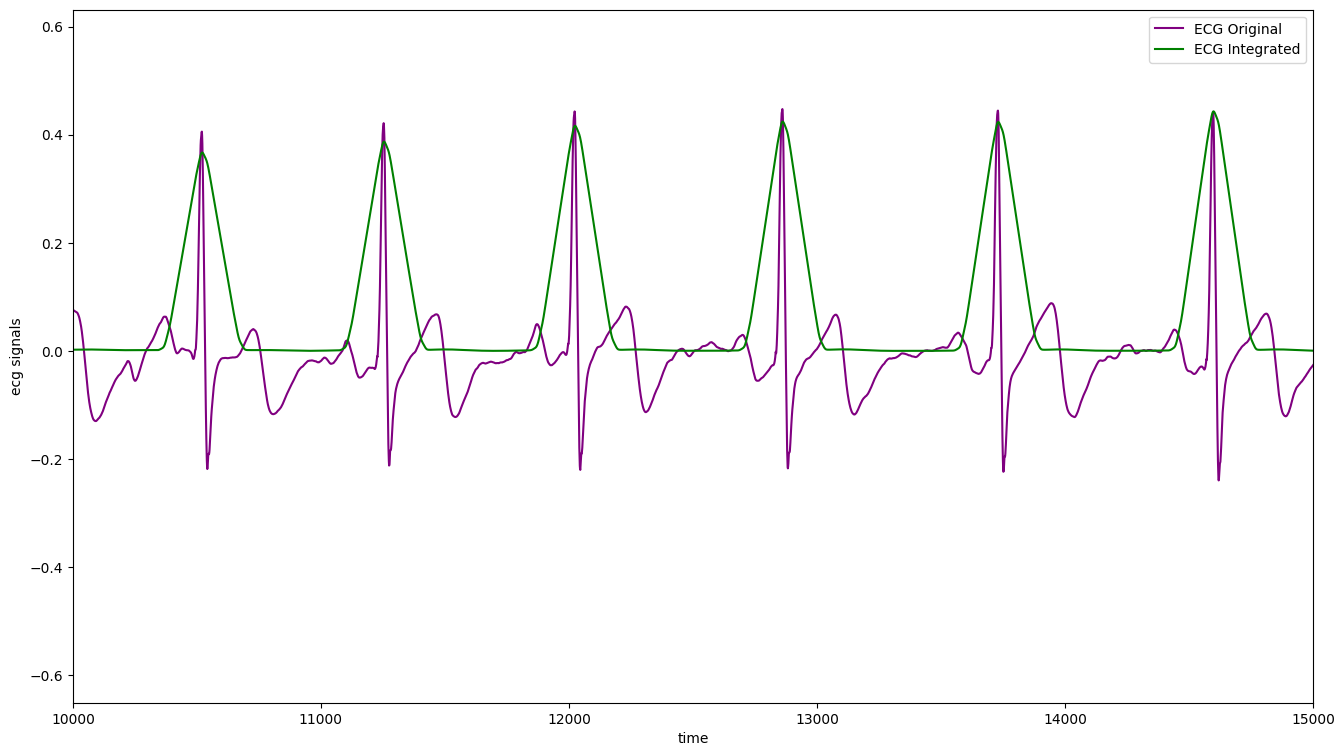

In [15]:
N_integrator = fs*30/200
A = 1/N_integrator
h = A*np.ones(int(N_integrator))
ecg_integrated = sig.filtfilt(h, 1, ecg_squared)*1e6

plt.figure(figsize=(16,9))
plt.plot(ecg,color="purple")
plt.plot(ecg_integrated,color="green")
plt.xlim(10000,15000)
plt.xlabel("time")
plt.ylabel("ecg signals")
plt.legend(["ECG Original","ECG Integrated"])
print(ecg_integrated)

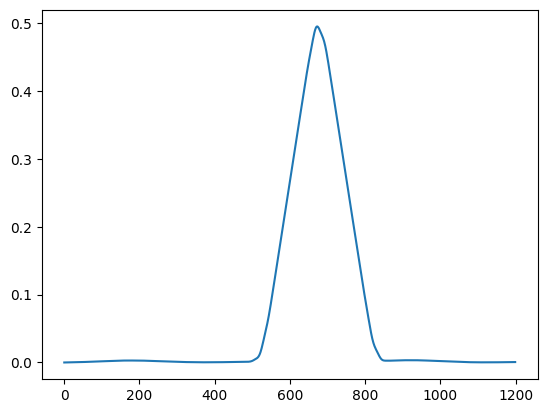

In [19]:
plt.plot(ecg_integrated[0:1200])